In [2]:
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.hysteresis import *

# Importing libraries
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

import time
import warnings

import matplotlib.pyplot as plt
import numpy as np

from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.functions_bw import bw_boundaries_all_points
from OSCC_postprocessing.rotation.rotate_crop import generate_CropRect, generate_plume_mask
from OSCC_postprocessing.analysis.multihole_utils import (
    preprocess_multihole,
    resolve_backend,
    rotate_segments_with_masks,
    compute_td_intensity_maps,
    estimate_peak_brightness_frames,
    # estimate_hydraulic_delay,
    compute_penetration_profiles,
    clean_penetration_profiles,
    binarize_plume_videos,
    compute_cone_angle_from_angular_density,
    estimate_offset_from_fft,
    triangle_binarize_gpu as _triangle_binarize_gpu,  # Backward compatibility
)

from OSCC_postprocessing.analysis.single_plume import (
    pre_processing_mie,
)

from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
    rotate_video_nozzle_at_0_half_numpy,
)
warnings.filterwarnings("ignore", category=RuntimeWarning)

global timing
timing = True

if timing:
    import time
import numpy as np
from OSCC_postprocessing.io.async_npz_saver import AsyncNPZSaver
from OSCC_postprocessing.io.async_avi_saver import *
from OSCC_postprocessing.filters.video_filters import *
from OSCC_postprocessing.playback.video_playback import *
from OSCC_postprocessing.analysis.single_plume import (
    USING_CUPY,
    cp,
    _min_max_scale,
    _rotate_align_video_cpu,
    binarize_single_plume_video,
    bw_boundaries_all_points_single_plume,
    bw_boundaries_xband_filter_single_plume,
    filter_schlieren,
    linear_regression_fixed_intercept,
    penetration_bw_to_index,
    pre_processing_mie,
    ransac_fixed_intercept,
    save_boundary_csv,
    to_numpy,
)
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.binary_ops.binarized_metrics import processing_from_binarized_video
import pandas as pd

# Import rotation utility based on backend availability to avoid hard Cupy dependency
if USING_CUPY:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    from OSCC_postprocessing.rotation.rotate_with_alignment_cpu import (
        rotate_video_nozzle_at_0_half_numpy as rotate_video_nozzle_at_0_half_backend,
    )


from OSCC_postprocessing.analysis.multihole_utils import *
from OSCC_postprocessing.binary_ops.functions_bw import *
from OSCC_postprocessing.filters.video_filters import median_filter_video_auto, sobel_5x5_kernels, filter_video_fft
from OSCC_postprocessing.filters.svd_background_removal import godec_like
from OSCC_postprocessing.analysis.cone_angle import angle_signal_density_auto
from OSCC_postprocessing.filters.bilateral_filter import (
    bilateral_filter_video_cpu,
    bilateral_filter_video_cupy,
    bilateral_filter_video_volumetric_chunked_halo,
)
from OSCC_postprocessing.io.async_avi_saver import AsyncAVISaver
import numpy as np
import scipy.ndimage as ndi
from scipy.ndimage import binary_fill_holes
import os
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed
from OSCC_postprocessing.binary_ops.functions_bw import _triangle_threshold_from_hist, _boundary_points_one_frame
from OSCC_postprocessing.analysis.multihole_utils import triangle_binarize_gpu as _triangle_binarize_gpu
from OSCC_postprocessing.filters.bilateral_filter import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Check the hardware used for image processing

use_gpu, triangle_backend, xp = resolve_backend(use_gpu="auto", triangle_backend="auto")

print("CUDA is used:", use_gpu)

print("xp represents numpy or cupy? :",xp)

# Selecting image rotation solver based on available hardware
if use_gpu:
    from OSCC_postprocessing.rotation.rotate_with_alignment import (
        rotate_video_nozzle_at_0_half_cupy as rotate_video_nozzle_at_0_half_backend,
    )
else:
    rotate_video_nozzle_at_0_half_backend = rotate_video_nozzle_at_0_half_numpy

from OSCC_postprocessing.cine.functions_videos import *
from pathlib import Path
import json
from OSCC_postprocessing.binary_ops.masking import *
from OSCC_postprocessing.filters.convolution_2D_rawKernel import *
from OSCC_postprocessing.analysis.hysteresis import * 

def _as_numpy(arr):
    if USING_CUPY and hasattr(arr, "__cuda_array_interface__"):
        return cp.asnumpy(arr)
    return np.asarray(arr)

CUDA is used: True
xp represents numpy or cupy? : <module 'cupy' from 'c:\\Users\\Jiang\\Documents\\Mie_Py\\Mie_Postprocessing_Py\\.venv311\\Lib\\site-packages\\cupy\\__init__.py'>


In [242]:
# The only manual inputs in this file
file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T19\1.cine")
json_file = Path(r"G:\OSCC\LubeOil\BC20241003_HZ_Nozzle1\cine\T19\config.json")

In [243]:
# Video is in uint12 
video_bits = 12
brightness_levels = 2.0**video_bits
gamma = 1.0

frames_before_SOI = 10
frame_limit = 80

# Load the .cine file into a 3D numpy array (gray scale, shape: (Frame, Height, Width))
video = load_cine_video(file, frame_limit=120)
# Normalize the grayscale video to [0, 1] brightness range
video = xp.asarray(video)/ brightness_levels

F, H, W = video.shape

# Json file contains the metadata
with open(json_file, 'r', encoding='utf-8') as f:
    # Load metadata
    data = json.load(f)
    number_of_plumes = int(data['plumes'])
    # offset = float(data['offset']) # Not used in multi hole (Calculated later by FFT)
    centre = (float(data['centre_x']), float(data['centre_y']))
    ir_ = float(data["inner_radius"])   # inner radius (Injector radius)
    or_ = float(data["outer_radius"])   # outer radius (Quatz window radius)



print(f"The injector has {number_of_plumes} plumes.")
print(f"The nozzle is centred at ({centre[0]:.2f}, {centre[1]:.2f}) in image coordinates.")

Video Info - Width: 768, Height: 768, Frames: 120
The injector has 10 plumes.
The nozzle is centred at (392.50, 378.37) in image coordinates.


Text(0.5, 1.0, 'Ring mask based on calibrated inner & outer radius')

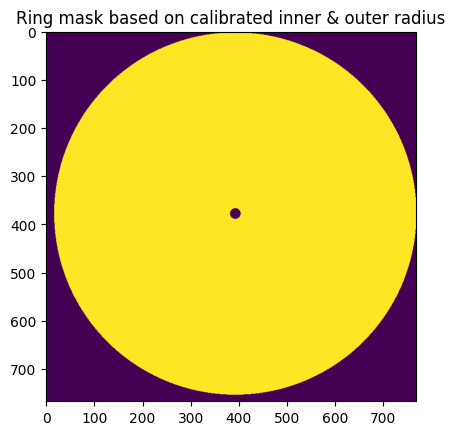

In [244]:
# Create annular mask between inner and outer radius to focus on spray region
ring_mask = generate_ring_mask(H, W, centre, ir_, or_, xp)
plt.imshow(_as_numpy(ring_mask))
plt.title("Ring mask based on calibrated inner & outer radius")

In [245]:
# === Linear Background Subtraction ===
# Use mean of first few frames as background reference
bkg = xp.median(video[:frames_before_SOI], axis=0, keepdims=True)

# === Background Subtraction ===
linear_foreground = xp.clip(video - bkg, 0, 1)  # Subtract background (avoid in-place to preserve original)


# === Scale ===
linear_foreground = _min_max_scale(linear_foreground)

# === Apply Ring Mask ===
linear_foreground_masked = linear_foreground * ring_mask[None, :, :]  # Apply mask to all frames

In [246]:
# === Logarithmic Background Subtraction ===
eps = 1e-9

# Log of video
lg_video = xp.log(video + eps)

# Median of blank frames in log space 
lg_bkg = xp.median(lg_video[:frames_before_SOI], axis=0, keepdims=True)

# === Background Subtraction in log space ===
lg_foreground = xp.exp(lg_video - lg_bkg) # Well defined, no negative values 

# === Scale === 
lg_foreground = _min_max_scale(lg_foreground)

# === Apply the mask ===

lg_foreground_masked = lg_foreground * ring_mask[None, :, :]

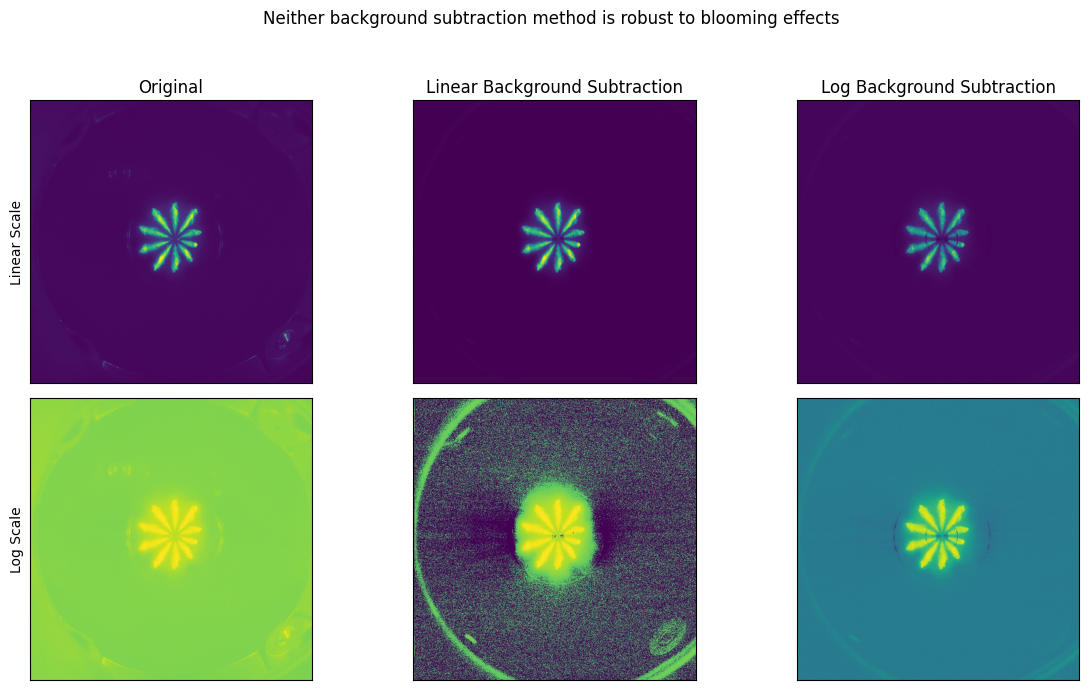

In [247]:
frame_num = 19

fig, ax = plt.subplots(2, 3, figsize=(12, 7))

ax[0, 0].imshow(_as_numpy(video[frame_num]))
ax[1, 0].imshow(_as_numpy(xp.log(video[frame_num] + 1e-9)))

ax[0, 1].imshow(_as_numpy(linear_foreground[frame_num]))
ax[1, 1].imshow(_as_numpy(xp.log(linear_foreground[frame_num] + 1e-9)))

ax[0, 2].imshow(_as_numpy(lg_foreground[frame_num]))
ax[1, 2].imshow(_as_numpy(xp.log(lg_foreground[frame_num] + 1e-9)))

ax[0, 0].set_title("Original")
ax[0, 1].set_title("Linear Background Subtraction")
ax[0, 2].set_title("Log Background Subtraction")
ax[0, 0].set_ylabel("Linear Scale")
ax[1, 0].set_ylabel("Log Scale")

for axis in ax.ravel():
    axis.set_xticks([])
    axis.set_yticks([])

fig.suptitle("Neither background subtraction method is robust to blooming effects", y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95])

In [248]:
# === Filtering after background subtraction === 


wsize=3
sigma=1

# === Highpass filter + linearly subtracted foreground ===
sobel_x = make_kernel("sobel", wsize, sigma, direction="x")
sobel_y = make_kernel("sobel", wsize, sigma, direction="y")


sb_filt_x = convolution_2D_cupy(linear_foreground, sobel_x)
sb_filt_y = convolution_2D_cupy(linear_foreground, sobel_y)
sb_mag = xp.sqrt(sb_filt_x ** 2 + sb_filt_y ** 2)


# linear_foreground_highpass = xp.clip(sb_mag, 0, 1)

linear_foreground_highpass = _min_max_scale(sb_mag)


# === Highpass filter + logarithmically subtracted foreground ===
sb_filt_x = convolution_2D_cupy(lg_foreground, sobel_x)
sb_filt_y = convolution_2D_cupy(lg_foreground, sobel_y)
sb_mag = xp.sqrt(sb_filt_x ** 2 + sb_filt_y ** 2)


# lg_foreground_highpass = xp.clip(sb_mag, 0, 1)

lg_foreground_highpass = _min_max_scale(sb_mag)




Text(0.5, 0, 'Sobel + Log BKG subtraction')

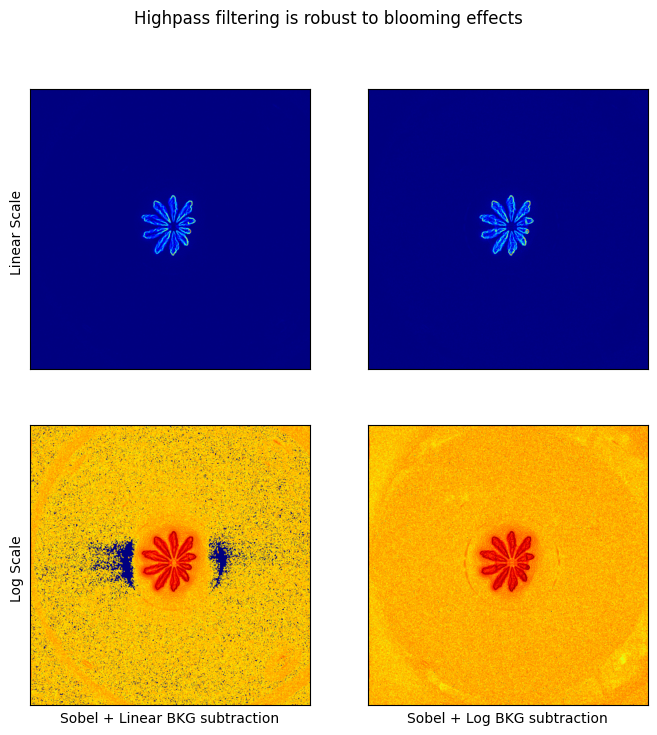

In [249]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

frame_num = 18

ax[0, 0].imshow(_as_numpy((linear_foreground_highpass[frame_num])), cmap="jet")
ax[0, 1].imshow(_as_numpy((lg_foreground_highpass[frame_num])), cmap="jet")

ax[1, 0].imshow(_as_numpy(xp.log(linear_foreground_highpass[frame_num]+eps)), cmap="jet")
ax[1, 1].imshow(_as_numpy(xp.log(lg_foreground_highpass[frame_num]+eps)), cmap="jet")

for axis in ax.ravel():
    axis.set_yticks([])
    axis.set_xticks([])

fig.suptitle("Highpass filtering is robust to blooming effects")

ax[0, 0].set_ylabel("Linear Scale ")
ax[1, 0].set_ylabel("Log Scale ")

ax[1, 0].set_xlabel("Sobel + Linear BKG subtraction")
ax[1, 1].set_xlabel("Sobel + Log BKG subtraction")  

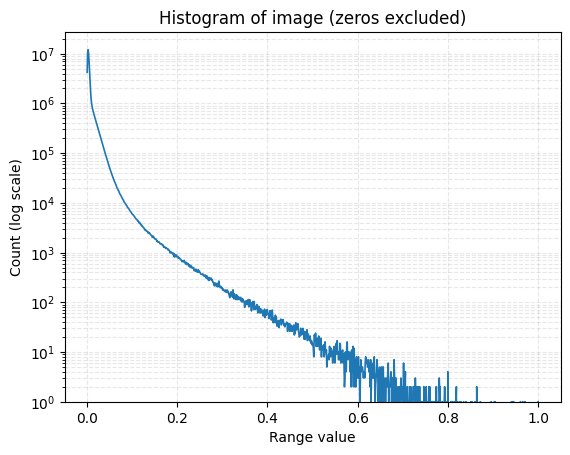

In [265]:
# imhist(_as_numpy((linear_foreground_highpass[frame_num])), log=True)
# imhist(_as_numpy((lg_foreground_highpass[frame_num])), log=True)
imhist(_as_numpy((lg_foreground_highpass)), exclude_zero=True, log=True)

In [251]:
# === Triangular Binarization ===
# Global Threshold for the whole video
bw_foreground = triangle_binarize_gpu(lg_foreground_highpass) * ring_mask[None, :, :]


Text(0.5, 0, 'Binarized')

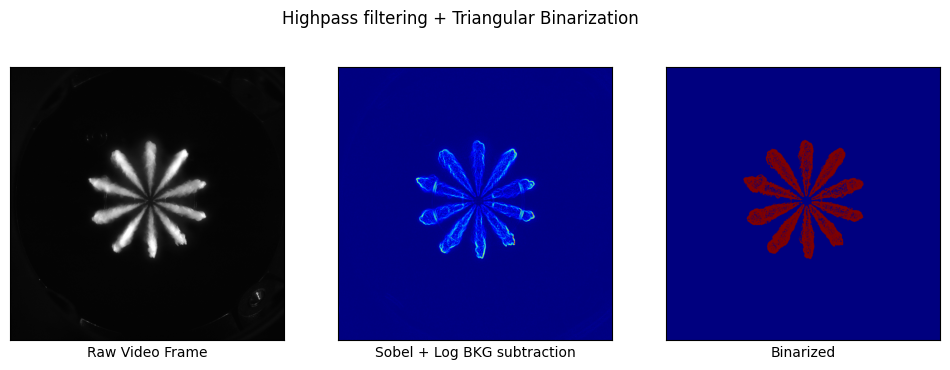

In [266]:
# Demo binarizing results
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

frame_num = 25
ax[0].imshow(_as_numpy((video[frame_num])), cmap="gray")
ax[1].imshow(_as_numpy((lg_foreground_highpass[frame_num])), cmap="jet")
ax[2].imshow(_as_numpy((bw_foreground[frame_num])), cmap="jet")


for axis in ax.ravel():
    axis.set_yticks([])
    axis.set_xticks([])

fig.suptitle("Highpass filtering + Triangular Binarization")

ax[0].set_xlabel("Raw Video Frame")
ax[1].set_xlabel("Sobel + Log BKG subtraction")
ax[2].set_xlabel("Binarized")  

In [253]:
energy_highpass = xp.sum(lg_foreground_highpass, axis=(1,2))

maximum_gain_compensation = 2.0

# Find the brightest frame and their intensity for each plume
brightness_peaks = _as_numpy(xp.argmax(energy_highpass).item())
peak_intensity_sums = xp.max(energy_highpass)

# Normalize the intensity of the brightest frame to 1 for each plume
energy_highpass /= peak_intensity_sums

gain_curves = xp.ones_like(energy_highpass)

eps = 1e-9

    # Correct the gain compensation after the brightest frame,
    # Assume they decline after the brightest frame,
    # And there is only one peak 
gain_curves[int(brightness_peaks):] = 1.0/(eps+energy_highpass[int(brightness_peaks):])

gain_curves = xp.clip(gain_curves, 0.0, maximum_gain_compensation)


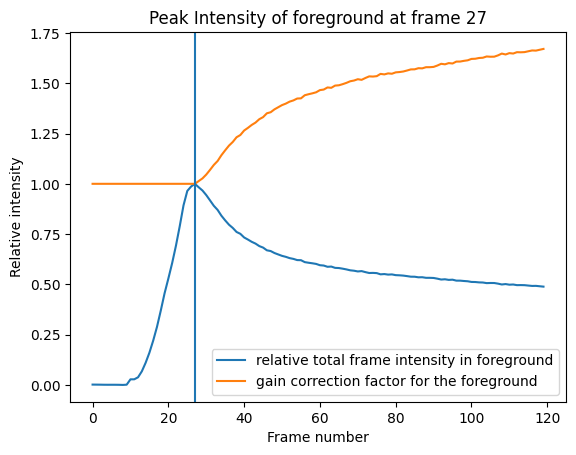

In [254]:
plt.plot(_as_numpy(_min_max_scale(energy_highpass)), label="relative total frame intensity in foreground")
plt.plot(_as_numpy(gain_curves), label="gain correction factor for the foreground")
plt.axvline(_as_numpy(brightness_peaks))
plt.title(f"Peak Intensity of foreground at frame {brightness_peaks}")
plt.xlabel("Frame number")
plt.ylabel("Relative intensity")
plt.legend()

In [255]:
# === Apply gain compensation
lg_foreground_highpass_compensated = lg_foreground_highpass * gain_curves[:, None, None]

# === Triangular Binarization ===
# Global Threshold for the whole video
bw_foreground = triangle_binarize_gpu(lg_foreground_highpass_compensated) * ring_mask[None, :, :]

# Global Threshold for the whole video

bw_per_frame_foreground = np.zeros_like(bw_foreground)

for f in range(bw_per_frame_foreground.shape[0]):
    bw_per_frame_foreground[f] = triangle_binarize_gpu(lg_foreground_highpass[f]) * ring_mask[None, :, :]

Text(0.5, 0, 'Binarized (per frame threshold)')

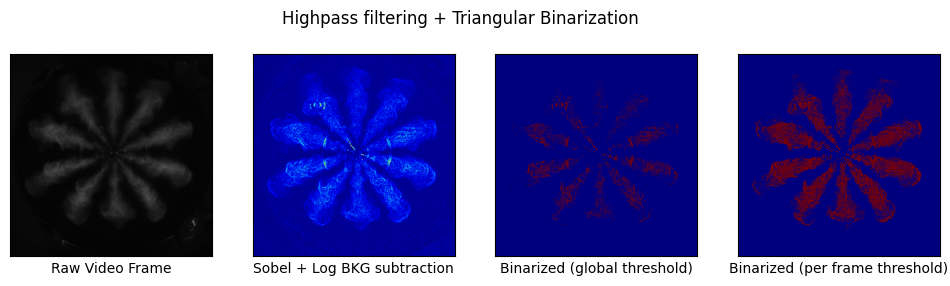

In [262]:
# Demo binarizing results
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

frame_num = 80
ax[0].imshow(_as_numpy((video[frame_num])), cmap="gray")
ax[1].imshow(_as_numpy((lg_foreground_highpass_compensated[frame_num])), cmap="jet")
ax[2].imshow(_as_numpy((bw_foreground[frame_num])), cmap="jet")
ax[3].imshow(_as_numpy((bw_per_frame_foreground[frame_num])), cmap="jet")

for axis in ax.ravel():
    axis.set_yticks([])
    axis.set_xticks([])

fig.suptitle("Highpass filtering + Triangular Binarization")

ax[0].set_xlabel("Raw Video Frame")
ax[1].set_xlabel("Sobel + Log BKG subtraction")
ax[2].set_xlabel("Binarized (global threshold)")  
ax[3].set_xlabel("Binarized (per frame threshold)")

In [257]:
bw_foreground_unified = xp.zeros_like(video)

bw_foreground_unified[:int(brightness_peaks)] = triangle_binarize_gpu(lg_foreground_highpass[:int(brightness_peaks)]* ring_mask[None, :, :]) 

for f in range(F):
    if f >= int(brightness_peaks):
        bw_foreground_unified[f] = triangle_binarize_gpu(lg_foreground_highpass[f]) * ring_mask[None, :, :]


Text(0.5, 0, 'Binarized')

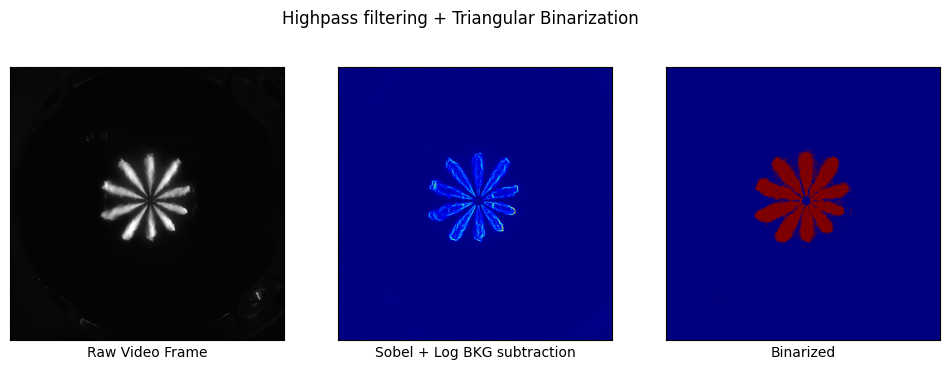

In [258]:
frame_num = 22

# Demo binarizing results
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(_as_numpy((video[frame_num])), cmap="gray")
ax[1].imshow(_as_numpy((lg_foreground_highpass_compensated[frame_num])), cmap="jet")
ax[2].imshow(_as_numpy((bw_foreground_unified[frame_num])), cmap="jet")

for axis in ax.ravel():
    axis.set_yticks([])
    axis.set_xticks([])

fig.suptitle("Highpass filtering + Triangular Binarization")

ax[0].set_xlabel("Raw Video Frame")
ax[1].set_xlabel("Sobel + Log BKG subtraction")
ax[2].set_xlabel("Binarized")  


In [ ]:
def mie_multihole_preprocessing(
                                video, 
                                ring_mask,
                                wsize=3,
                                sigma=1,
                                maximum_gain_compensation=2.0
                                ):

        # === Logarithmic Background Subtraction ===
        eps = 1e-9

        # Log of video
        lg_video = xp.log(video + eps)

        # Median of blank frames in log space 
        lg_bkg = xp.median(lg_video[:frames_before_SOI], axis=0, keepdims=True)

        # === Background Subtraction in log space ===
        lg_foreground = xp.exp(lg_video - lg_bkg) # Well defined, no negative values 

        # === Scale === 
        lg_foreground = _min_max_scale(lg_foreground)

        # === Apply the mask ===
        # lg_foreground_masked = lg_foreground * ring_mask[None, :, :]

        # === Highpass filter + linearly subtracted foreground ===
        sobel_x = make_kernel("sobel", wsize, sigma, direction="x")
        sobel_y = make_kernel("sobel", wsize, sigma, direction="y")

        # === Highpass filter + logarithmically subtracted foreground ===
        sb_filt_x = convolution_2D_cupy(lg_foreground, sobel_x)
        sb_filt_y = convolution_2D_cupy(lg_foreground, sobel_y)
        sb_mag = xp.sqrt(sb_filt_x ** 2 + sb_filt_y ** 2)

        # Scale linearly to [0, 1]
        lg_foreground_highpass = _min_max_scale(sb_mag)
        
        # Frame-wise sum
        energy_highpass = xp.sum(lg_foreground_highpass, axis=(1,2))

        # Find the brightest frame and their intensity for each plume
        brightness_peaks = _as_numpy(xp.argmax(energy_highpass).item())

        # Normalize the intensity of the brightest frame to 1 for each plume
        peak_intensity_sums = xp.max(energy_highpass)
        energy_highpass /= peak_intensity_sums

        # Correct the gain compensation after the brightest frame,
        # Assume they decline after the brightest frame,
        # And there is only one peak
        # eps = 1e-9 
        gain_curves = xp.ones_like(energy_highpass)
        gain_curves[int(brightness_peaks):] = 1.0/(eps+energy_highpass[int(brightness_peaks):])
        gain_curves = xp.clip(gain_curves, 0.0, maximum_gain_compensation)

        lg_foreground_highpass_compensated = lg_foreground_highpass * gain_curves[:, None, None]

        # Binairzing the whole video
        bw_foreground_unified = xp.zeros_like(video)

        # === Global Threshold ===
        bw_foreground_unified = triangle_binarize_gpu(lg_foreground_highpass_compensated)

        '''
        bw_foreground_unified[:int(brightness_peaks)] = triangle_binarize_gpu(lg_foreground_highpass[:int(brightness_peaks)]) 

        for f in range(F):
            if f >= int(brightness_peaks):
                bw_foreground_unified[f] = triangle_binarize_gpu(lg_foreground_highpass[f]) 
        '''

        '''
        # Experiment with using the brightest frame as global threshold
        _, thres = triangle_binarize_from_float(lg_foreground_highpass[int(brightness_peaks)].get())
        
        bw_foreground_unified = lg_foreground_highpass >= thres /255.0
        '''

        bw_foreground_unified*= ring_mask[None, :, :]

        return lg_foreground, lg_foreground_highpass_compensated, bw_foreground_unified

In [260]:
fg, hp, bw = mie_multihole_preprocessing(
                                video, 
                                ring_mask,
                                )

In [261]:
# play_videos_side_by_side((_as_numpy(video), _as_numpy(fg), ), intv=100)

play_videos_side_by_side((_as_numpy(hp*5.0), _as_numpy(bw*255.0)), intv=100)